# Gaussianization Flows - Details

In [1]:
#@title Install Packages
# %%capture
try:
    import sys, os
    from pyprojroot import here

    # spyder up to find the root
    root = here(project_files=[".here"])

    # append to path
    sys.path.append(str(here()))
except ModuleNotFoundError:
    %%capture
    import os
    os.system("pip install objax chex")
    os.system("pip install git+https://github.com/IPL-UV/rbig_jax.git#egg=rbig_jax")

In [2]:
# jax packages
import jax
import jax.numpy as np
from jax.config import config
# import chex
config.update("jax_enable_x64", False)

import objax
import chex
import numpy as onp
from functools import partial

# library functions
from rbig_jax.data import get_classic
from rbig_jax.plots import plot_joint, plot_joint_prob, plot_info_loss
from rbig_jax.transforms.mixture import MixtureGaussianCDF
from rbig_jax.transforms.inversecdf import InverseGaussCDF
from rbig_jax.transforms.linear import HouseHolder
from rbig_jax.transforms.base import CompositeTransform


# logging
import tqdm
import wandb

# plot methods
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import HTML

sns.reset_defaults()
sns.set_context(context="talk", font_scale=0.7)

%matplotlib inline
%load_ext autoreload
%autoreload 2

## Demo Data

<Figure size 432x288 with 0 Axes>

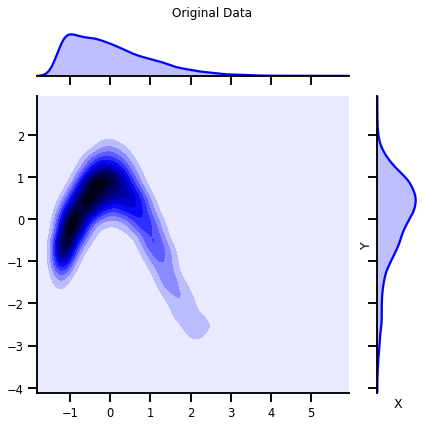

In [85]:
from sklearn.preprocessing import StandardScaler
# %%wandb
# get data
n_samples = 2_000
n_features = 2
data = get_classic(10_000)
data = StandardScaler().fit_transform(data)

# plot data
plot_joint(data, "blue", "Original Data", kind='kde', logger=False)

### Model

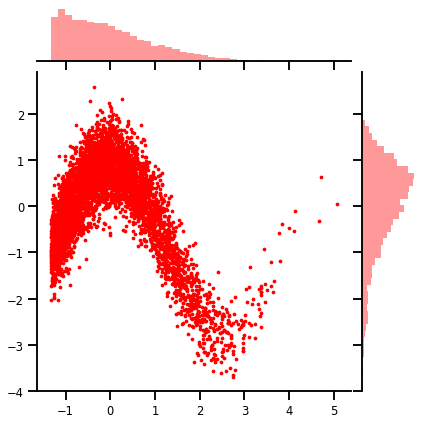

In [133]:
n_samples = 5_000
n_features = 2

# generate data
data = get_classic(n_samples)
x_transform = StandardScaler()
data = x_transform.fit_transform(data)
X = np.array(data, dtype=np.float32)
X = jax.device_put(X)
sns.jointplot(X[:, 0], X[:, 1], s=5, color='red')
plt.savefig("./data.png")

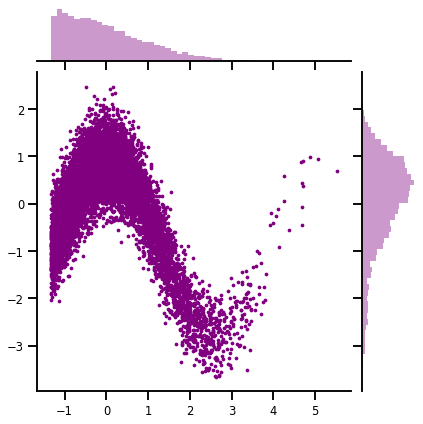

In [117]:

n_plot_samples = 10_000
data_plot = get_classic(n_plot_samples)
data_plot = x_transform.transform(data_plot)
X_plot = np.array(data_plot, dtype=np.float32)
X_plot = jax.device_put(X_plot)
sns.jointplot(X_plot[:, 0], X_plot[:, 1], s=5, color='purple')

#### Layer 1 - Mixture Gaussian CDF Transform

In [118]:
%%time
# model components
n_components = 10
n_reflections = 10

# initialize model
layer_1 = MixtureGaussianCDF(n_features=n_features, n_components=n_components)


# forward transformation
X_l1, logabsdet = layer_1(X)

CPU times: user 1.66 s, sys: 23.4 ms, total: 1.69 s
Wall time: 1.63 s


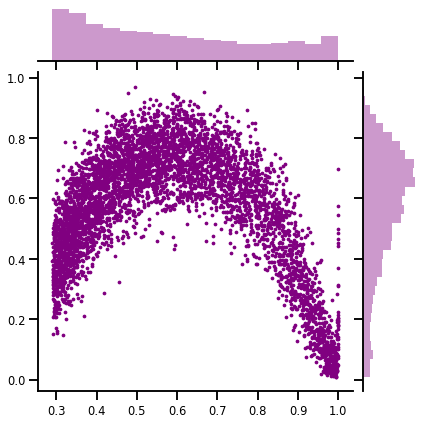

In [119]:
# plot data
sns.jointplot(X_l1[:, 0], X_l1[:, 1], s=5, color='purple')

#### Layer III - Logit Transformation

In [120]:
# initialize model
model_layer2 = InverseGaussCDF()

# forward transformation
X_l2, logabsdet = model_layer2(X_l1)

/home/emmanuel/.conda/envs/jax_py38/lib/python3.8/site-packages/jax/lax/lax.py:6190: UserWarning: Explicitly requested dtype float64 requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))


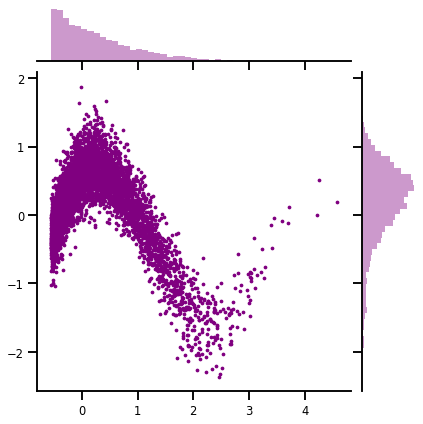

In [121]:
sns.jointplot(X_l2[:, 0], X_l2[:, 1], s=5, color='purple')

#### Layer 3 - HouseHolder Transformation

In [122]:
# layer hyperparameters
learn = 10
n_reflections = 10
generator = objax.random.Generator(123)

# initialize model
model_layer3 = HouseHolder(n_features=n_features, n_reflections=n_reflections, generator=generator)

# forward transformation
Z, logabsdet = model_layer2(X_l2)

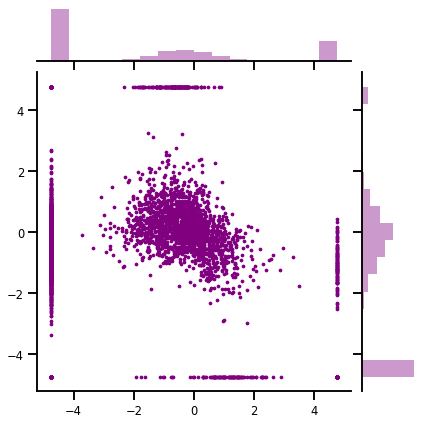

In [123]:
sns.jointplot(Z[:, 0], Z[:, 1], s=5, color='purple')

## Gaussianization Flows

In [124]:
from rbig_jax.models.gaussflow import GaussianizationFlow
from rbig_jax.transforms.logit import Logit

In [125]:
# model hyperparameters
n_components = 20
n_reflections = 2
generator = objax.random.Generator(123)
learn_temperature = True
n_features = data.shape[1]


n_layers = 4

transforms = []

for _ in range(n_layers):
    # mixture gaussian cdf distribution, f:[-inf,inf] -> [0,1]
    transforms.append(
        MixtureGaussianCDF(n_features=n_features, n_components=n_components)
    )
    # Logit quantile function, f:[0,1] -> [-inf,inf]
    transforms.append(
        Logit(learn_temperature=learn_temperature)
    )
    # orthogonal rotation layer
    transforms.append(
        HouseHolder(n_features=n_features, n_reflections=n_reflections, generator=generator)
    )
    
# compose all transformations into a single chain
transform = CompositeTransform(transforms)

# initialize base distribution
base_dist = jax.scipy.stats.norm

# initialize Model
gf_model = GaussianizationFlow(n_features=n_features, bijections=transform, base_dist=base_dist)

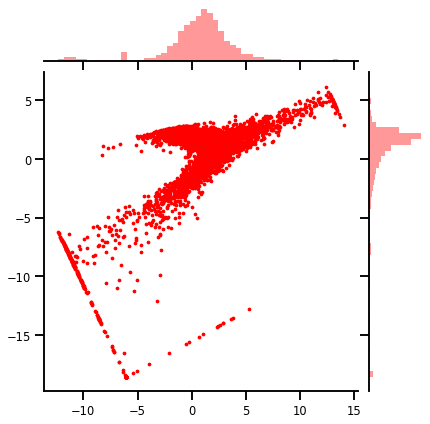

In [126]:
Z, _ = gf_model(X)

sns.jointplot(Z[:, 0], Z[:, 1], s=5, color='red')

#### Loss Function

We're going to use the negative Log-Likelihood

In [127]:
@objax.Function.with_vars(gf_model.vars())
def nll_loss(x):
    return gf_model.score(x)

In [128]:
nll_loss(data)

DeviceArray(16.555227, dtype=float32)

##### Optimizer

In [129]:
# define the optimizer
opt = objax.optimizer.Adam(gf_model.vars())

# get grad values
gv = objax.GradValues(nll_loss, gf_model.vars())
lr = 0.01
epochs = 500
batch_size = 128

# define the training operation
@objax.Function.with_vars(gf_model.vars() + opt.vars())
def train_op(x):
    g, v = gv(x)  # returns gradients, loss
    opt(lr, g)
    return v

# This line is optional: it is compiling the code to make it faster.
train_op = objax.Jit(train_op)

#### Testing

100%|██████████| 500/500 [02:18<00:00,  3.62it/s, loss=1.8923]


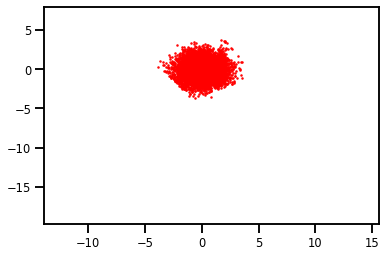

In [130]:
import itertools
from jax import device_put
import tqdm
from jax import random
from celluloid import Camera


# initialize parameters
key = random.PRNGKey(123)
itercount = itertools.count()
permute_rng, rng = random.split(key)

losses = list()


# initialize figure
fig = plt.figure()
camera = Camera(fig)

pbar = tqdm.trange(epochs)

with pbar:
    for i in pbar:
        
        if (i + 1) % 20 == 0 or i < 20:
            # make predictions
            Z = gf_model.transform(X_plot)
            plt.scatter(Z[:, 0], Z[:, 1], s=1, color="Red")
            camera.snap()

        # batch processing
        permute_rng, rng = random.split(rng)

        # randomly shuffle the data
        train_data = random.permutation(permute_rng, X)

        # Train
        avg_loss = []

        for batch_index in range(0, n_samples, batch_size):
            # compute loss
            loss = float(train_op( train_data[batch_index:batch_index+batch_size])[0])
            # append batch
            avg_loss.append(loss)
        # average loss
        batch_loss = np.mean(np.stack(avg_loss))

        # Log losses
        losses.append(batch_loss)
        pbar.set_postfix({"loss": f"{batch_loss:.4f}"})
        

            
animation = camera.animate(250)
# HTML(animation.to_html5_video())
animation.save('training.gif')

#### Losses

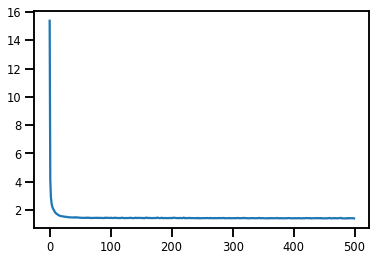

In [60]:
plt.plot(losses)

#### Forward Transformation

In [61]:
# forward transformation
z, logabsdet = gf_model(np.array(data))

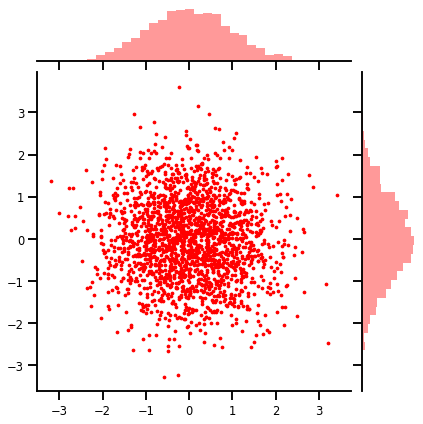

In [62]:
sns.jointplot(z[:, 0], z[:, 1], s=5, color='red')

### Application I - Generating Samples

In [63]:
# generate samples in the latent domain
n_gen_samples = 1_000
z_samples = objax.random.normal(shape=(n_gen_samples, n_features), generator=generator)

# inverse transformation
x_samples = gf_model.inverse_transform(z_samples)

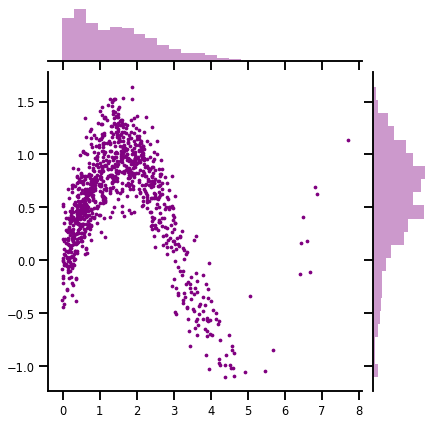

In [64]:
sns.jointplot(x_samples[:, 0], x_samples[:, 1], s=5, color='purple')

### Probability Density Estimation

In [65]:
ngrid = 1_000
buffer = 0.1
xline = np.linspace(data[:,0].min()-buffer, data[:,0].max()+buffer, ngrid)
yline = np.linspace(data[:,1].min()-buffer, data[:,1].max()+buffer, ngrid)
xgrid, ygrid = np.meshgrid(xline, yline)
xyinput = np.concatenate([xgrid.reshape(-1, 1), ygrid.reshape(-1, 1)], axis=1)

In [66]:
# forward transformation
z, logabsdet = gf_model(xyinput)

In [67]:
# log probability
z_prob = jax.scipy.stats.norm.logpdf(z).sum(axis=1)

# change of variables
log_prob = z_prob + logabsdet

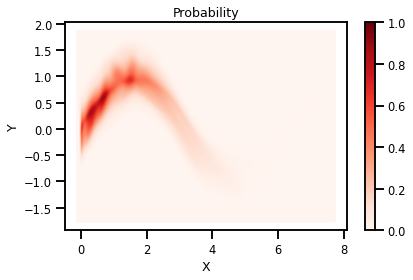

In [131]:
cmap = "Reds"
probs = np.exp(log_prob)
# probs = np.clip(probs, 0.0, 1.0)
title = "Probability"

fig, ax = plt.subplots()
h = ax.scatter(xyinput[:, 0], xyinput[:, 1], s=1, c=probs,  cmap=cmap, vmin=0.0, vmax=1.0)
plt.xlabel("X")
plt.ylabel("Y")
plt.colorbar(h)
ax.set_title(title)
plt.tight_layout()
plt.savefig("./probs.png")
plt.show()

### Demo of Transform between Layers

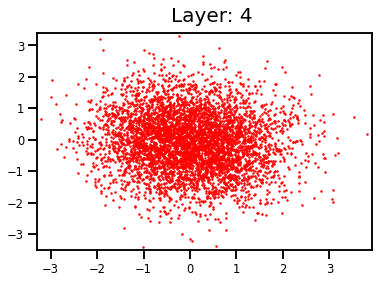

In [144]:
# initialize figure
fig, ax = plt.subplots()
camera = Camera(fig)

outputs = data
# ax.scatter(outputs[:, 0], outputs[:, 1], s=1, color="Red")
# ax.set_xlim([outputs[:,0].min()-.1, outputs[:,0].max()+.1])
# ax.set_ylim([outputs[:,1].min()-.1, outputs[:,1].max()+.1])
# ax.text(0.4, 1.05, f"Layer: {0}", transform=ax.transAxes, fontsize=20)
# camera.snap()


for ilayer, itransform in enumerate(gf_model.bijections._transforms):
    outputs = itransform.transform(outputs)    
    
    if (ilayer + 1) % 3 == 0:
        # make predictions
        ax.scatter(outputs[:, 0], outputs[:, 1], s=1, color="Red")
        ax.set_xlim([outputs[:,0].min()-.1, outputs[:,0].max()+.1])
        ax.set_ylim([outputs[:,1].min()-.1, outputs[:,1].max()+.1])
        ax.text(0.4, 1.05, f"Layer: {int((ilayer+1)/3)}", transform=ax.transAxes, fontsize=20)
        camera.snap()

animation = camera.animate(1_500)
# HTML(animation.to_html5_video())
animation.save('./layers.gif')